In [2]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import os
import cv2
import torchshow as ts
from tqdm import tqdm
from dataloader.loader import generator
import yaml
import utils.utils as ut
import matplotlib.pyplot as plt
import math
ut.set_random_seed(1221)
with open('config/config.yaml', 'r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
import utils.utils as utils
import torch.optim as optim
from utils.utils import AverageMeter, batch_intersection_union, write_logger, set_random_seed
import itertools
from sklearn import metrics
import datetime
import timm
import yaml

set_random_seed(1441)

with open('config/config.yaml', 'r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)

with torch.no_grad():
    test_model = timm.create_model(cfg['model_params']['encoder'], pretrained= False, features_only=True, out_indices=[4])
    in_planes = test_model(torch.randn((2,3,128,128)))[0].shape[1]
    del test_model

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

from model.model import ConSegNet
model = ConSegNet(cfg, in_planes).to(device)
pretrained_params = []
other_params = []
for key in list(model.named_parameters()):
    if len(key[0].split('encoder.')) == 2:
        pretrained_params.append(key[1])
    else:
        other_params.append(key[1])


if cfg['dataset_params']['dataset_name'] == 'caisa':
    from dataloader.loader import generator
elif cfg['dataset_params']['dataset_name'] == 'imd_2020':
    from dataloader.loader_imd import generator


gnr = generator(cfg)
training_generator = gnr.get_train_generator()
validation_generator = gnr.get_val_generator()


In [58]:
my_list = ['encoder.']
pretrained_params = []
other_params = []
for key in list(model.named_parameters()):
    if len(key[0].split('encoder.')) == 2:
        pretrained_params.append(key[1])
    else:
        other_params.append(key[1])
    
# params = list(filter(lambda kv: kv[0] in my_list, model.named_children()))
# base_params = list(filter(lambda kv: kv[0] not in my_list, model.named_parameters()))

In [67]:
import torch.optim as optim
optimizer = optim.SGD([{'params': pretrained_params, 'lr' : 1e-6}, 
            {'params': other_params}], 
            lr = cfg['model_params']['lr'], weight_decay = 1e-4, momentum = 0.9)

In [13]:
root_dir = '/home/agency/xai/forgery/IMD2020'
all_files = os.listdir(root_dir)
train_all_IDs = {}
mask_all_IDs = {}
count = 0
for files in all_files:
    all_file = os.listdir(os.path.join(root_dir,files))
    for file_name in all_file:
        if len(file_name.split('_0.jpg'))==2:
            train_all_IDs[count] = files+'/'+file_name
            mask_all_IDs[count] = files+'/'+file_name.split('_0.jpg')[0]+'_0_mask.png'
            count +=1
rand = np.random.choice(len(train_all_IDs), math.ceil(len(train_all_IDs)*0.1), replace=False).tolist()

train_IDs = {}
mask_IDs = {}
test_IDs = {}
mask_test_IDs = {}

count = 0
test_count = 0
for i in range(len(train_all_IDs)):
    if i in rand:
        test_IDs[test_count] = os.path.join(root_dir,train_all_IDs[i])
        mask_test_IDs[test_count] = os.path.join(root_dir,mask_all_IDs[i])
        test_count += 1
    else:
        train_IDs[count] = os.path.join(root_dir,train_all_IDs[i])
        mask_IDs[count] = os.path.join(root_dir,mask_all_IDs[i])
        count += 1

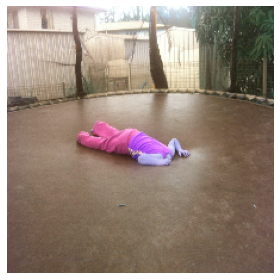

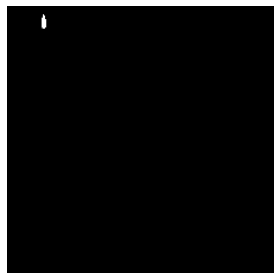

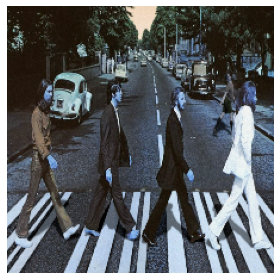

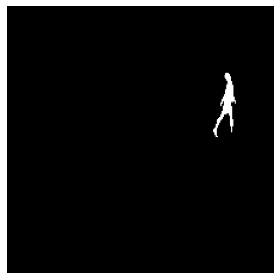

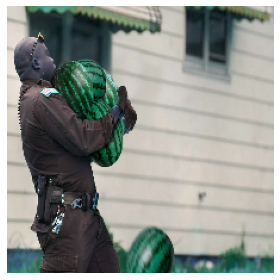

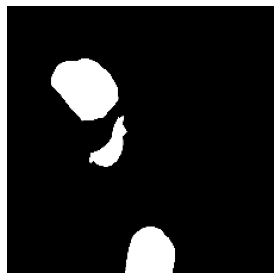

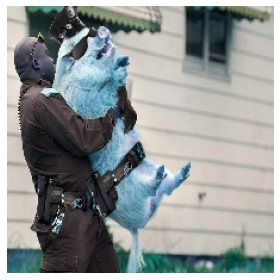

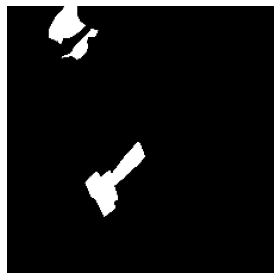

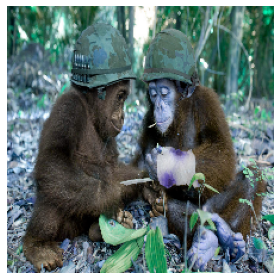

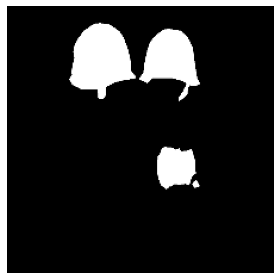

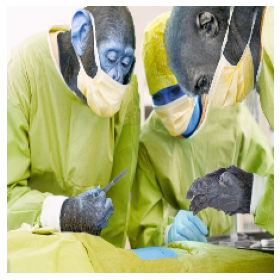

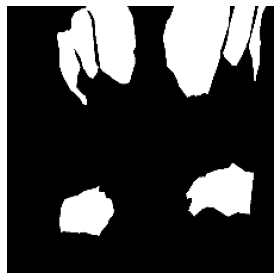

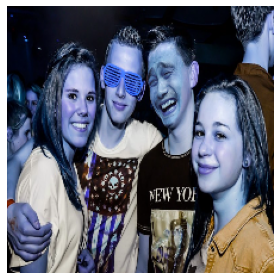

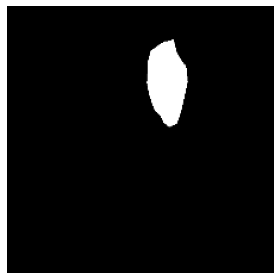

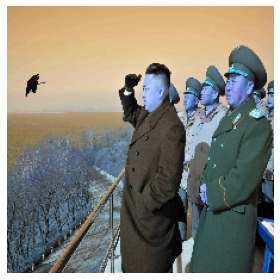

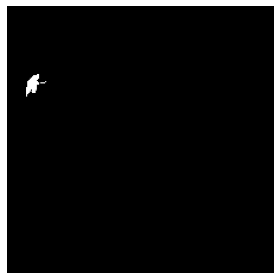

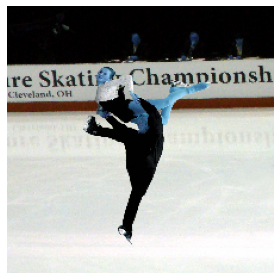

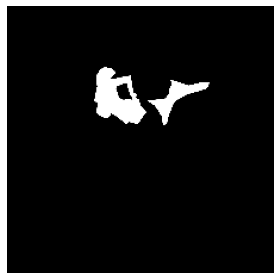

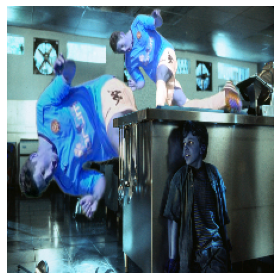

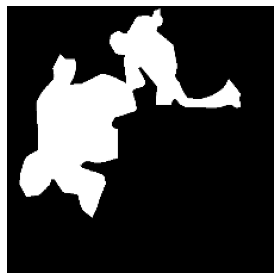

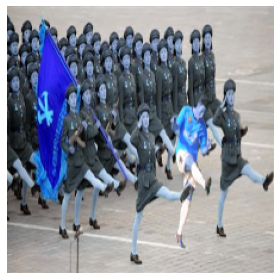

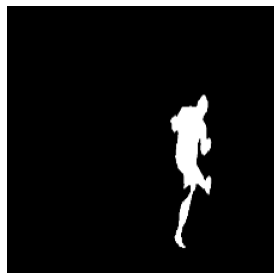

In [16]:
for i in range(len(train_IDs)):
    img = cv2.imread(test_IDs[i])
    img = cv2.resize(img, (224,224))
    img = torch.from_numpy(img)
    ts.show(img)
    mask = cv2.imread(mask_test_IDs[i])
    mask = cv2.resize(mask, (224,224))
    mask = torch.from_numpy(mask)
    ts.show(mask)
    if i==10:
        break

In [22]:
for file_name in all_file:
    print(file_name)
    print(file_name.split('_0.jpg'))

c9t437l_0_mask.png
['c9t437l_0_mask.png']
1drczk_orig.jpg
['1drczk_orig.jpg']
c9t437l_0.jpg
['c9t437l', '']


In [7]:
all_file

['c9t437l_0_mask.png', '1drczk_orig.jpg', 'c9t437l_0.jpg']

In [2]:
from model.mantranet import MantraNet
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model=MantraNet(device=device).cuda()

In [3]:
ut.set_random_seed(1221)
gnr = generator(cfg)
train_gen = gnr.get_train_generator()
val_gen = gnr.get_val_generator()

In [8]:
for img, mask in tqdm(val_gen):
    out = model(img.cuda())
    print(out.shape)
    break
    

  0%|          | 0/275 [00:00<?, ?it/s]

torch.Size([2, 1, 224, 224])


In [9]:
_, predict = torch.max(out, 1)
print(predict.shape)

torch.Size([2, 224, 224])


In [7]:
print(out.shape)

torch.Size([2, 224, 224])


In [19]:
count = 0
from tqdm import tqdm
for i in tqdm(range(len(casiav1_files))):
    filename = casiav1_files[i].split('.')[0]
    for j in range(len(casiav1_masks)):
        mask_name = casiav1_masks[j].split('.')[0].split('_gt')[0]
        if filename == mask_name:
            f = open('/home/agency/xai/forgery/wacv/dataloader/casiav1_train.txt', "a")
            f.write(casiav1_files[i] + "\n")
            f.close()
            f = open('/home/agency/xai/forgery/wacv/dataloader/casiav1_mask.txt', "a")
            f.write(casiav1_masks[j] + "\n")
            f.close()
            

100%|██████████| 921/921 [00:00<00:00, 3617.50it/s]


In [15]:
print(casiav1_masks[j])
print(casiav1_files[i])

Sp_D_NNN_R_cha0084_sec0061_0369_gt.png
Sp_D_NNN_R_cha0084_sec0061_0369.jpg


In [17]:
msk = cv2.imread('/home/agency/xai/forgery/CASIA1/Gt/Sp/Sp_D_NNN_R_cha0084_sec0061_0369_gt.png',0)
msk.shape

(256, 384)

In [ ]:
with open('config/config.yaml', 'r') as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)

train = train_generator(cfg)
val = val_generator(cfg)